In [8]:
using DataFrames, CSV

# 1. Importar el dataset iris.csv
df = CSV.read("datasets/iris.csv", DataFrame)

# 2. Crear las columnas binarias (asumiendo que hay una columna llamada "species")
transform!(df, 
    :target => ByRow(isequal("Iris-setosa")) => :setosa,
    :target => ByRow(isequal("Iris-versicolor")) => :versicolor,
    :target => ByRow(isequal("Iris-virginica")) => :virginica
)

df.setosa = Float64.(df.setosa) 
df.versicolor = Float64.(df.versicolor)
df.virginica = Float64.(df.virginica)

# Visualizar el resultado
println(first(df, 5))  # Mostrar las primeras 5 filas

5×8 DataFrame
 Row │ sepal_length  sepal_width  petal_length  petal_width  target       setosa   versicolor  virginica 
     │ Float64       Float64      Float64       Float64      String15     Float64  Float64     Float64   
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────
   1 │          5.1          3.5           1.4          0.2  Iris-setosa      1.0         0.0        0.0
   2 │          4.9          3.0           1.4          0.2  Iris-setosa      1.0         0.0        0.0
   3 │          4.7          3.2           1.3          0.2  Iris-setosa      1.0         0.0        0.0
   4 │          4.6          3.1           1.5          0.2  Iris-setosa      1.0         0.0        0.0
   5 │          5.0          3.6           1.4          0.2  Iris-setosa      1.0         0.0        0.0


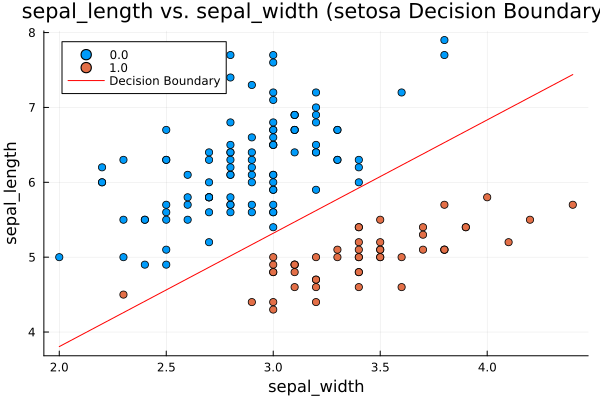

In [9]:
using GLM, Plots

function plot_decision_boundary(df, feature1, feature2, target_species, decision_threshold=0.5)
    
    # 3. Estimación del modelo de regresión lineal (usando term para evitar interpolación)
    formula = @eval @formula($(Symbol(target_species)) ~ $(Symbol(feature1)) + $(Symbol(feature2)))
    model = lm(formula, df)

    # 4. Extraer los coeficientes
    b0 = coef(model)[1]
    b1 = coef(model)[2]
    b2 = coef(model)[3]

    # 5. Crear un rango de valores para la segunda característica (feature2)
    feature2_range = range(minimum(df[:, Symbol(feature2)]), stop=maximum(df[:, Symbol(feature2)]), length=100)

    # 6. Calcular los valores correspondientes de la primera característica (feature1)
    feature1_pred = (decision_threshold .- b0 .- b2 .* feature2_range) ./ b1 

    # 7. Crear un gráfico de dispersión
    scatter(df[:, Symbol(feature2)], df[:, Symbol(feature1)], group=df[:, Symbol(target_species)],
            xlabel=feature2, ylabel=feature1, legend=:topleft,
            title="$feature1 vs. $feature2 ($target_species Decision Boundary)")

    # 8. Añadir la línea
    plot!(feature2_range, feature1_pred, color=:red, label="Decision Boundary")
end

plot_decision_boundary(df, "sepal_length", "sepal_width", "setosa")

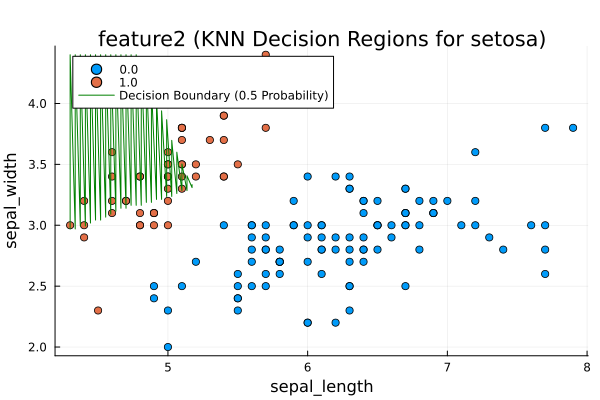

In [10]:
using NearestNeighbors, Plots, DataFrames, Statistics, StatsBase

function plot_knn_decision_boundary(df, feature1, feature2, target_species, control=0.5; k=5)

    # Extraer las características y la variable objetivo
    X = Matrix(df[:, [Symbol(feature1), Symbol(feature2)]])
    y = df[:, Symbol(target_species)]

    # Crear el KDTree
    kdtree = KDTree(X')

    # Crear una malla
    x1_range = range(minimum(X[:, 1]), stop=maximum(X[:, 1]), length=100)
    x2_range = range(minimum(X[:, 2]), stop=maximum(X[:, 2]), length=100)
    grid_points = [[x1, x2] for x1 in x1_range for x2 in x2_range]

    # Concatenar los puntos de la malla
    flat_grid_points = hcat(grid_points...)

    # Predecir las clases de los puntos de la malla
    idxs, _ = knn(kdtree, flat_grid_points, k, true)
    y_pred = [mean(y[idxs[i]]) for i in 1:size(flat_grid_points, 2)]

    y_pred_rounded = round.(y_pred, digits=2)

    # Data para el gráfico
    plot_df = DataFrame(
        x1 = first.(grid_points),
        x2 = last.(grid_points),
        y_pred_rounded = y_pred_rounded 
    )

    # Filtrar los puntos de la frontera
    boundary_points = filter(:y_pred_rounded => ==(control), plot_df)
    sort!(boundary_points, :x1)  # Sort by x1

    # Grafico y regiones de decisión
    scatter(X[:, 1], X[:, 2], group=y,
            xlabel=feature1, ylabel=feature2, legend=:topleft,
            title="
feature2 (KNN Decision Regions for $target_species)")
    plot!(boundary_points.x1, boundary_points.x2, color=:green, label="Decision Boundary (0.5 Probability)")
end

plot_knn_decision_boundary(df, "sepal_length", "sepal_width", "setosa", k=100)